In [25]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import mmcv
import importlib
import torch
import torchvision.transforms as transforms
from mmcv import Config
from mmcls.datasets.pipelines import Compose
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from PIL import Image
import heapq
from mmseg.apis import inference_segmentor, init_segmentor
from mmseg.core.evaluation import get_palette
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

from scripts import generate_statistics_single
from scripts import visualization_seg_masks
from scripts import generate_statistics
from scripts import generate_cams
from scripts import utils
from scripts.utils.pipeline import get_pipeline_torchvision
from scripts import generate_segs
from scripts import visualize_cam_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
configSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/ocrnet_hr48_512x512_carparts_noflip.py'
checkpointSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/latest.pth'
imgRootTrain = '../data/CompCars_sv_original_split/train'
imgRootVal = '../data/CompCars_sv_original_split/val'
configCAMResOG = '../CAMModels/resnet/compCars_Original/resnet50_b128x2_compcars-original-split.py'
checkpointCAMResOG = '../CAMModels/resnet/compCars_Original/latest.pth'
configCAMSwinSmallOG = '../CAMModels/swinSmall/compCars_Original/swin-small_b128x2_compcars-original-split.py'
checkpointCAMSwinSmallOG = '../CAMModels/swinSmall/compCars_Original/latest.pth'
annfileTrain = '../annfileTrain.txt'
annfileVal = '../annfileVal.txt'
annfileValGt = '../annfileValGt.txt'
imgNameTrain='Acura_Acura_ILX_2a6cce617fc27d.jpg'
imgNameVal = 'Acura_Acura_ILX_3c11ef9e42931b.jpg'
imgPathTrain=os.path.join(imgRootTrain, imgNameTrain)
imgPathVal=os.path.join(imgRootVal, imgNameVal)

paletteName='Comp_Original_Ocrnet_Carparts_Noflip'

segDataPath = '../preGenData/Segmentations/CompCars_Original/valAllSegs.npz'

camDataGradCAM = '../preGenData/CompCars_original/ResNet/valAllCAMs.npz'
camDataEigenCAM = '../preGenData/CompCars_original/ResNet/valAllCAMsEigen.npz'
camDataEigenGrad = '../preGenData/CompCars_original/ResNet/valAllCAMsEigenGrad.npz'
camDataGradCAMGPU = '../preGenData/CompCars_original/ResNet/valAllCAMsGPU.npz'
camDataGradCAMPlusPlus = '../preGenData/CompCars_original/ResNet/valAllCAMsGrad++.npz'
camDataLayerCAM = '../preGenData/CompCars_original/ResNet/valAllCAMsLayer.npz'
camDataXCAM = '../preGenData/CompCars_original/ResNet/valAllCAMsXGrad.npz'

C:\Users\Linus\Desktop\XAI-Vehicle-Classification\scripts\generate_statistics_single.py:171: UserWarning: Specifiyng segData will lead to image Data not being generated. Ignoring parameter.
  warnings.warn('Specifiyng segData will lead to image Data not being generated. Ignoring parameter.')


Calculating segmentation results.
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 0.3 task/s, elapsed: 3s, ETA:     0sUsing given CAM Data.
Loading data from file at ../preGenData/CompCars_original/ResNet/valAllCAMs.npz
Output path is not a directory. Using base directory: ./results.
Saving images to: ./results\Overview.jpg


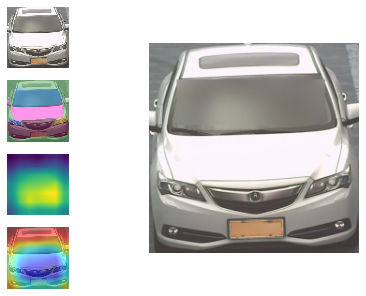

In [24]:
generate_statistics_single.plot(imgRoot=imgRootVal, imgName=imgNameVal, 
                                segData=segDataPath, camData=camDataGradCAM,
                                segConfig=configSeg, segCheckpoint=checkpointSeg,
                                camConfig=configCAMResOG)

In [179]:
visualize_cam_results.visualize_cpu_vs_gpu(imgRoot=imgRootVal, CPUcamData=camDataGradCAM, GPUcamData=camDataGradCAMGPU,
                                          annfile=annfileVal, dataClasses=['Acura_Acura_ILX'], camConfig=configCAMResOG,
                                          visType='heatmap')

Generate results for type heatmap
Using given CAM Data.
Loading data from file at ../preGenData/CompCars_original/ResNet/valAllCAMsGPU.npz
Using given CAM Data.
Loading data from file at ../preGenData/CompCars_original/ResNet/valAllCAMs.npz
Saving images into directory imgs
(224, 224)
(224, 224)
Saving image to: imgs\Acura_Acura_ILX_3c11ef9e42931b_heatmap.jpg
(224, 224)
(224, 224)
Saving image to: imgs\Acura_Acura_ILX_3f182088df7c66_heatmap.jpg
(224, 224)
(224, 224)
Saving image to: imgs\Acura_Acura_ILX_7ec5dcfce68270_heatmap.jpg
